In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [3]:
IMAGE_SHAPE = (224, 224)

classifier = keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,)),
])

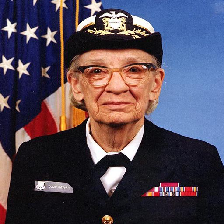

In [4]:
grace_hopper = keras.utils.get_file('image.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [5]:
grace_hopper = np.array(grace_hopper) / 255.0
grace_hopper.shape

(224, 224, 3)

In [6]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [7]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [8]:
labels_path = keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


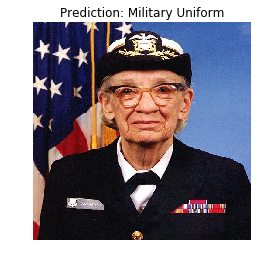

In [18]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title('Prediction: ' + predicted_class_name.title())

In [19]:
data_root = keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 144s 1us/step


In [20]:
image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [21]:
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [22]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [25]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['cabbage butterfly', 'guillotine', 'daisy', 'vase', 'daisy',
       'daisy', 'daisy', 'park bench', 'daisy', 'garden spider', 'daisy',
       'dung beetle', 'daisy', 'bee', 'daisy', "yellow lady's slipper",
       'coral fungus', 'hip', 'daisy', 'daisy', 'daisy', 'garden spider',
       'flamingo', 'stinkhorn', 'cardoon', 'bee', "yellow lady's slipper",
       'cardoon', 'sleeping bag', 'daisy', 'daisy', 'daisy'], dtype='<U30')

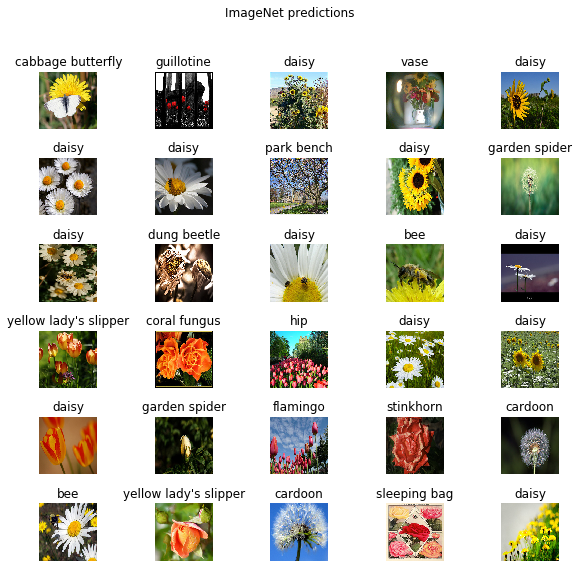

In [26]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [27]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

In [28]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224, 224, 3))

In [29]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [31]:
feature_extractor_layer.trainable = False

In [33]:
model = keras.Sequential([
    feature_extractor_layer,
    layers.Dense(image_data.num_classes, activation='softmax'),
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [34]:
predictions = model(image_batch)

In [35]:
predictions.shape

TensorShape([32, 5])

In [37]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['acc'],
)

In [41]:
class CollectBatchStats(keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
        
    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [42]:
steps_per_epoch = np.ceil(image_data.samples / image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks=[batch_stats_callback])

Epoch 1/2
115/115 [==============================] - 341s 3s/step - loss: 0.7143 - acc: 0.8125
Epoch 2/2
115/115 [==============================] - 37772s 328s/step - loss: 0.3474 - acc: 0.8438
